# Figure 3

In [46]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
import utils as lu
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/processing_FISH/utils.py'>

In [2]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of FISH data
dir_fish = '/home/louiscam/projects/gpcr/data/fish_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

# Load FISH data

### Load genomic scale FISH data
Including for each locus whether the genes measured within it are actively transcribing and the distances from the locus to the nuclear lamina, the nearest nuclear speckle and the nearest nucleolus.

In [3]:
# Load data
merfish_data = pd.read_csv(dir_fish+'dna_merfish_data.tsv', sep='\t', header=0)

In [4]:
# Build dictionary from Eensembl gene name to HGNC
enst2hgnc_df = pd.read_csv(dir_genome+'ensemblGene2Name', sep='\t', header=0)
enst2hgnc_df.columns = ['ENST', 'HGNC']
enst2hgnc_df = enst2hgnc_df.set_index('ENST')
ensg2enst_df = pd.read_csv(dir_genome+'ensemblGene2Transcript2Protein', sep='\t', header=0)
ensg2enst_df.columns = ['ENSG', 'ENST', 'ENSP']
ensg2enst_df = ensg2enst_df[['ENSG', 'ENST']]
ensg2enst_df = ensg2enst_df.set_index('ENST')
ensg2hgnc_df = ensg2enst_df.join(enst2hgnc_df, how='outer').reset_index()
ensg2hgnc_df = ensg2hgnc_df[['ENSG', 'HGNC']].drop_duplicates(['ENSG', 'HGNC'])
ensg2hgnc_df['HGNC'] = ensg2hgnc_df['HGNC'].str.upper()
ensg2hgnc_df = ensg2hgnc_df.reset_index()[['ENSG', 'HGNC']]
ensg2hgnc = {ensg2hgnc_df.loc[i,'ENSG']: ensg2hgnc_df.loc[i,'HGNC'] for i in range(len(ensg2hgnc_df))}

In [5]:
# Add gene information to MERFISH data
merfish_data['gene names'] = merfish_data['gene names'].astype(str)
merfish_data['gene names'] = merfish_data['gene names'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['gene_hgnc'] = merfish_data['gene names'].apply(lambda x: [ensg2hgnc[g] if (g in ensg2hgnc.keys()) 
                                                                    else 'unknown' for g in x] if len(x)>0 else [])
merfish_data['n_genes'] = merfish_data['gene_hgnc'].apply(lambda x: len(x))
merfish_data['transciption'] = merfish_data['transciption'].astype(str)
merfish_data['transciption'] = merfish_data['transciption'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['chrom'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[0]

In [6]:
# Reduce data (drop NAs, chrX and gene-less loci)
merfish_data = merfish_data.dropna(how='any')
merfish_data = merfish_data[merfish_data['chrom']!='chrX']
merfish_data = merfish_data[['cell number',
                             'chrom',
                             'homolog number',
                             'genomic coordinate',
                             'gene_hgnc',
                             'transciption',
                             'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data.columns = [ 'cell_ID',
                         'chrom',
                         'homolog',
                         'probe_locus',
                         'gene_ID',
                         'transcription',
                         'x(nm)', 'y(nm)', 'z(nm)']

# Load genes of interest

In [8]:
# Genes that we want to validate
g1 = np.array(['SHARPIN', 'HRAS', 'SLC16A3', 'CD151', 'PLEC', 'UBE2I', 
               'CFL1', 'PIP5K1C', 'PKD1', 'SHC1', 'TESK1', 'TLN1'])
# Negative controls in GM12878
with open(saving_dir+'validation_genes_GM12878.pkl', 'rb') as f:
    g2 = pickle.load(f)
# Load all adhesome genes
with open(saving_dir+'all_adhesome_genes.pkl', 'rb') as f:
    all_adhesome_genes = pickle.load(f)
# Load active adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Combined genes
combined_adhesome_genes = np.unique(np.concatenate([g1, g2, all_adhesome_genes]))

In [44]:
# Sample random non-adhesome active genes
with open(saving_dir+'all_active_genes.pkl', 'rb') as f:
    all_active_genes = pickle.load(f)
np.random.seed(13)
active_gene_pool = np.array(list(set(all_active_genes)-set(active_adhesome_genes)))
random_active_genes = np.sort(np.random.choice(active_gene_pool, size=len(active_adhesome_genes), replace=False))

In [10]:
# Genes for downstream analysis
selected_genes = np.concatenate([active_adhesome_genes, random_active_genes])
print(f'Number of selected genes = {len(selected_genes)}')

Number of selected genes = 404


In [11]:
# Location of genes in hg38
df_loc = pd.read_csv(dir_genome+'chrom_hg38.loc', sep='\t', header=0)
df_loc = df_loc[df_loc['#chrom'].isin(['chr'+str(i) for i in range(1,23)])]
df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneName']]
df_loc.columns = ['chrom', 'start', 'end', 'geneName']
df_loc = df_loc.sort_values(['chrom','start','end'])
df_loc = df_loc.groupby(['chrom','geneName']).agg({'start':'min', 'end':'max'})
df_loc = df_loc.reset_index().sort_values(['chrom','start','end'])
df_loc_adhesome = df_loc[df_loc['geneName'].isin(selected_genes)]

In [12]:
# Identify adhesome genes present within 250kb of available MERFISH probes
resol = 1000000

In [12]:
# Construct a bed object for adhesome genes
df_adhesome_pos = df_loc_adhesome[['chrom','start','end', 'geneName']]
bed_adhesome = pybedtools.BedTool.from_dataframe(df_adhesome_pos).sort()
bed_adhesome_df = bed_adhesome.to_dataframe()

In [13]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos['start'] = (df_merfish_pos['start']-resol).clip(lower=0)
df_merfish_pos['end'] = (df_merfish_pos['end']+resol)
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [14]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_adhesome, c=[4], o='distinct', f=1e-9, F=1e-9)
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
merfishloc2gene = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

# Identify adhesome genes in MERFISH data

In [15]:
# Add adhesome genes information
merfish_data = merfish_data.reset_index().iloc[:,1:]
merfish_data['selected_genes'] = [merfishloc2gene[merfish_data.loc[i,'probe_locus']] 
                                  for i in range(len(merfish_data))]
merfish_data['n_selected_genes'] = merfish_data['selected_genes'].apply(lambda x: len(x))
merfish_data = merfish_data.loc[merfish_data['n_selected_genes']>0,:]

In [16]:
# Explode
merfish_data['gene_ID'] = merfish_data['gene_ID'].astype(str)
merfish_data['transcription'] = merfish_data['transcription'].astype(str)
fixed_cols = [ 'cell_ID','chrom','homolog','probe_locus','gene_ID','transcription',
              'x(nm)', 'y(nm)', 'z(nm)', 'n_selected_genes']
merfish_data = merfish_data.set_index(fixed_cols).apply(pd.Series.explode).reset_index()

In [20]:
# A few statistics
all_merfish_loci = np.unique(merfish_data["probe_locus"])
all_merfish_genes = np.unique(merfish_data["selected_genes"])
all_merfish_cells = np.unique(merfish_data["cell_ID"])
print(f'Number of unique loci = {len(all_merfish_loci)}')
print(f'Number of unique genes = {len(all_merfish_genes)}')
print(f'Number of unique cells = {len(all_merfish_cells)}')

Number of unique loci = 235
Number of unique genes = 284
Number of unique cells = 3533


In [24]:
# Build a dictionary where for each cell, we report a gene by gene distance matrix between adhesome genes
cell2distmat = {}
for cell in tqdm(all_merfish_cells):
    cell_data = merfish_data.loc[merfish_data['cell_ID']==cell,['x(nm)','y(nm)','z(nm)','selected_genes']]
    cell_data = cell_data.groupby('selected_genes').agg({'x(nm)': 'mean', 'y(nm)': 'mean', 'z(nm)': 'mean'})
    new_index = [x for x in selected_genes if (x in cell_data.index)]
    cell_data = cell_data.loc[new_index,:]
    dist_mat = squareform(pdist(cell_data, metric='euclidean'))
    cell2distmat[cell] = pd.DataFrame(dist_mat,columns = cell_data.index.values, index = cell_data.index.values)

100%|██████████| 3533/3533 [00:26<00:00, 133.57it/s]


In [29]:
# Combine information across all cells into one dataframe
distances_df = pd.DataFrame(0, columns=selected_genes, index=selected_genes)
n_samples_df = pd.DataFrame(0, columns=selected_genes, index=selected_genes)
for cell in tqdm(all_merfish_cells):
    cell_dist_mat = cell2distmat[cell]
    cell_idx = cell_dist_mat.index.values
    distances_df.loc[cell_idx, cell_idx] = distances_df.loc[cell_idx, cell_idx]+cell_dist_mat
    n_samples_df.loc[cell_idx, cell_idx] += 1 
n_samples_df = n_samples_df.replace(0, np.nan)


  9%|▊         | 306/3533 [00:34<05:54,  9.11it/s]


 18%|█▊        | 624/3533 [01:09<05:27,  8.87it/s]


 27%|██▋       | 939/3533 [01:44<04:36,  9.39it/s]


 36%|███▌      | 1261/3533 [02:20<04:21,  8.67it/s]


 44%|████▍     | 1571/3533 [02:55<03:34,  9.14it/s]


 53%|█████▎    | 1872/3533 [04:00<07:10,  3.86it/s]


 61%|██████▏   | 2169/3533 [04:48<02:38,  8.60it/s]


 70%|██████▉   | 2472/3533 [05:35<02:32,  6.97it/s]


 79%|███████▊  | 2778/3533 [06:18<01:24,  8.94it/s]


 87%|████████▋ | 3075/3533 [06:51<00:52,  8.73it/s]


 96%|█████████▌| 3389/3533 [07:27<00:16,  8.80it/s]


100%|██████████| 3533/3533 [07:42<00:00,  7.63it/s]


In [33]:
# Save important objects to pickle
with open(saving_dir+'merfish_data.pkl', 'wb') as f:
     pickle.dump(merfish_data, f)
with open(saving_dir+'merfish_cell2distmat.pkl', 'wb') as f:
     pickle.dump(cell2distmat, f)
with open(saving_dir+'merfish_distances_df.pkl', 'wb') as f:
     pickle.dump(distances_df, f)
with open(saving_dir+'merfish_nsamples_df.pkl', 'wb') as f:
     pickle.dump(n_samples_df, f)

# Final analysis

In [13]:
# Load pickles
with open(saving_dir+'merfish_data.pkl', 'rb') as f:
     merfish_data = pickle.load(f)
with open(saving_dir+'merfish_cell2distmat.pkl', 'rb') as f:
     cell2distmat = pickle.load(f)
with open(saving_dir+'merfish_distances_df.pkl', 'rb') as f:
     distances_df = pickle.load(f)
with open(saving_dir+'merfish_nsamples_df.pkl', 'rb') as f:
     n_samples_df = pickle.load(f)

In [56]:
# Average distance dataframe
avg_dist_df = distances_df/n_samples_df
avg_dist_df = avg_dist_df/avg_dist_df.max().max()
avg_prox_df = 1-avg_dist_df
final_adh_genes = np.sort([g for g in all_merfish_genes if (g in active_adhesome_genes)])
final_rand_genes = np.sort([g for g in all_merfish_genes if (g not in active_adhesome_genes)])

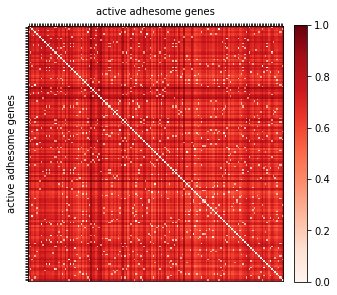

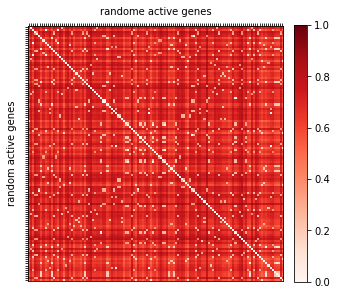

In [64]:
# Plot heatmaps
lu.plot_heatmap(avg_dist_df.loc[final_adh_genes, final_adh_genes],
                ['' for _ in final_adh_genes], ['' for _ in final_adh_genes], 
                'active adhesome genes', 'active adhesome genes', 
                size=5, fontsize=5,
                vmax=avg_dist_df.max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(avg_dist_df.loc[final_rand_genes, final_rand_genes],
                ['' for _ in final_rand_genes], ['' for _ in final_rand_genes], 
                'randome active genes', 'random active genes', 
                size=5, fontsize=5,
                vmax=avg_dist_df.max().max(), add_patches = [],
                cmap='Reds')

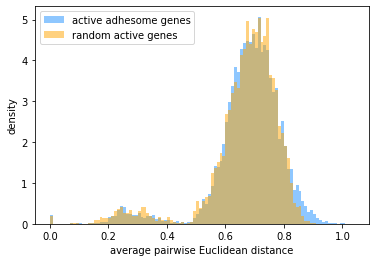

In [67]:
plt.figure()
plt.hist(avg_dist_df.loc[final_adh_genes,final_adh_genes].values[np.triu_indices(len(final_adh_genes),1)], 
         color='dodgerblue', alpha=0.5, density=True, bins=np.arange(0, 1.05, 0.01),
         label='active adhesome genes')
plt.hist(avg_dist_df.loc[final_rand_genes,final_rand_genes].values[np.triu_indices(len(final_rand_genes),1)], 
         color='orange', alpha=0.5, density=True, bins=np.arange(0, 1.05, 0.01),
         label='random active genes')
plt.xlabel('average pairwise Euclidean distance')
plt.ylabel('density')
plt.legend(loc='upper left')
plt.show()

In [60]:
avg_prox_df.loc[a,a].values[np.triu_indices(len(a),1)]

array([0.201675  , 0.31162183, 0.33658604, ..., 0.69086657, 0.21758085,
       0.20397813])